In [ ]:
import requests

url = "https://www.amazon.com/robots.txt"
response = requests.get(url)

if response.status_code == 200:
    print(response.text)
else:
    print(f"Failed to fetch robots.txt with status code: {response.status_code}")

In [ ]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import time
import csv

## THE CODE BELOW IS FOR SCRAPING AMAZON BESTSELLERS FROM 2000 TO 2024


# Initialize Selenium WebDriver
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Optional: Run in headless mode
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")

# Initialize the WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

base_url = "https://www.amazon.com/gp/bestsellers/{year}/books/ref=zg_bsar_cal_ye"
data = []

# Loop through years 2000 to 2024
for year in range(2000, 2025):
    print(f"Scraping year: {year}")
    url = base_url.format(year=year)
    driver.get(url)
    
    # Simulate lazy scrolling
    SCROLL_PAUSE_TIME = 1
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    
    # Parse the fully loaded page with BeautifulSoup
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    books = soup.select(".p13n-sc-uncoverable-faceout")
    print(f"Found {len(books)} books")
    for book in books:
        
        # Extract Rank
        rank_element = book.find_previous("span", class_="zg-bdg-text")
        rank = rank_element.text.strip("#") if rank_element else "N/A"
        
        # Extract Title
        title_element = book.select_one("._cDEzb_p13n-sc-css-line-clamp-1_1Fn1y")
        title = title_element.text.strip() if title_element else "N/A"
            
        # Extract Author
        author_element = (book.select_one(".a-size-small.a-link-child ._cDEzb_p13n-sc-css-line-clamp-1_1Fn1y") 
                          or book.select_one(".a-size-small ._cDEzb_p13n-sc-css-line-clamp-1_1Fn1y"))
        
        author = author_element.text.strip() if author_element else "N/A"
        
        format_element = book.select_one(".a-size-small.a-color-secondary.a-text-normal")
        book_format = format_element.text.strip() if format_element else "N/A"
        
        rating_element = book.select_one(".a-icon-alt")
        rating = rating_element.text.strip() if rating_element else "N/A"
        
        reviews_element = book.select_one(".a-icon-row span.a-size-small")
        reviews = reviews_element.text.strip() if reviews_element else "N/A"
        
        price_element = (book.select_one("._cDEzb_p13n-sc-price_3mJ9Z")
                        or book.select_one(".p13n-sc-price"))
        price = price_element.text.strip() if price_element else "N/A"
        
        data.append({
            "Year": year,
            "Rank": rank,
            "Title": title,
            "Author": author,
            "Cover": book_format,
            "Rating": rating,
            "Reviews": reviews,
            "Price": price,
        })
    with open("saved_datasets/amazon_bestsellers_2000_2024.csv", "w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=["Year", "Rank" ,"Title", "Author", "Cover" ,"Rating", "Reviews", "Price"])
        writer.writeheader()
        writer.writerows(data)

        print("Scraping complete. Data saved to 'amazon_bestsellers_2000_2024.csv'.")
    # else:
    #     print(f"Request failed with status code: {response.status_code}")
    time.sleep(6)
    

In [ ]:
import pandas as pd
import time
import urllib.parse
import re
from concurrent.futures import ThreadPoolExecutor
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz

## THE CODE BELOW IS FOR SCRAPING GOODREADS TAGS FOR EVERY BOOK OF THE AMAZON TOP 50 BESTSELLERS(2000-2024)

######################
# GLOBAL FUNCTIONS
######################
def load_tags(filename):
    """
    Helper function to read lines from a text file, stripping whitespace
    and ignoring blank lines.
    Returns a list of non-empty lines.
    """
    with open(filename, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

######################
# GLOBAL VARIABLES
######################
genre_cache = {}  # Cache for storing genre results
fiction_only_tags = set(load_tags("genre_tags/fiction_only_tags.txt"))
nonfiction_only_tags = set(load_tags("genre_tags/nonfiction_only_tags.txt"))
priority_tags = load_tags("genre_tags/priority_tags.txt")  # Keep as a list for ordering
other_tags = set(load_tags("genre_tags/other_tags.txt"))
# Load award datasets
pulitzer_prize_winners_fiction = pd.read_csv("awards_csv/pulitzer_winners_fiction.csv")
pulitzer_prize_winners_nonfiction = pd.read_csv("awards_csv/pulitzer_prize_nonfiction.csv")
nobel_prize_winners = pd.read_csv("awards_csv/nobel_prize_winners_litterature.csv")
booker_prize_winners = pd.read_csv("awards_csv/booker_winners.csv")
nebula_awards_novel = pd.read_csv("awards_csv/nebula_awards_novel.csv")
nebula_awards_novella = pd.read_csv("awards_csv/nebula_awards_novella.csv")
nebula_awards_shortstory = pd.read_csv("awards_csv/nebula_awards_shortstory.csv")
hugo_awards_novel = pd.read_csv("awards_csv/hugo_awards.csv")

######################
# 1. HELPER FUNCTIONS
######################

def generate_goodreads_url(title):
    """Generate a Goodreads search URL for a given title.
    Uses the current timestamp as a dummy qid to avoid caching issues.
    """
    base_url = "https://www.goodreads.com/search"
    qid = str(int(time.time()))  # Use the current timestamp as a dummy qid
    query = urllib.parse.quote(title)  # Encode the title properly
    return f"{base_url}?q={query}&qid={qid}"

def clean_title(title):
    """Remove extra text like (....) or [....] from the title."""
    return re.sub(r"\s*\(.*?\)|\[.*?\]", "", title).strip()

def simplify_title(title, max_words=7):
    """Simplify the title by
     - Removing text after colon
     - Cleaning parentheses/brackets
     - Limiting to the first `max_words` words"""
    # Remove text after colon
    title = re.split(r":", title)[0]
    # Clean parentheses/brackets and strip whitespace
    title = clean_title(title)
    # Limit to the first `max_words` words
    return " ".join(title.split()[:max_words])

def expand_title(title, max_length=10):
    """
    Expand the title by appending more words from the original title.
    Normalize the title to remove punctuation for consistency.
    """
    # Normalize punctuation (remove colons, commas, etc.)
    normalized_title = re.sub(r"[^\w\s]", "", title)  # Remove non-alphanumeric characters
    title_parts = normalized_title.split()

    # Ensure the expanded title does not exceed max_length
    if len(title_parts) < max_length:
        return " ".join(title_parts[:max_length])

    return title

def is_author_match(input_author, result_author):
    """Return True if authors are a likely match."""
    return fuzz.partial_ratio(input_author.lower(), result_author.lower()) > 80


###############################
# 2. FICTION/NONFICTION LOGIC
###############################
def classify_and_return_genres(genres):
    """
    Classify genres as Fiction, Nonfiction, or Other, and collect all sub-genres.
    """
    genre_set = set(genres)

    # Classify Fiction/Nonfiction/Other
    if "Fiction" in genre_set:
        fiction_status = "Fiction"
    elif "Nonfiction" in genre_set:
        fiction_status = "Nonfiction"
    elif genre_set & fiction_only_tags:
        fiction_status = "Fiction"
    elif genre_set & nonfiction_only_tags:
        fiction_status = "Nonfiction"
    elif genre_set & other_tags:
        fiction_status = "Other"
    else:
        fiction_status = "N/A"

    # Collect sub-genres (all matching priority tags)
    sub_genres = [tag for tag in genres if tag in priority_tags]

    return fiction_status, sub_genres

##############################
# 3. MAIN GENRE SCRAPER LOGIC
##############################
def get_cached_genre(title, author):
    """Check if the title-author combination is already cached."""
    cache_key = f"{title.lower()}|{author.lower()}"
    if cache_key in genre_cache:
        print(f"Using cached data for: {title} by {author}")
        return genre_cache[cache_key]
    return None

def send_goodreads_request(simplified_title):
    """Send a request to Goodreads and return the parsed results."""
    search_url = generate_goodreads_url(simplified_title)
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/91.0.4472.124 Safari/537.36"
        )
    }
    response = requests.get(search_url, headers=headers)
    if response.status_code == 200:
        search_soup = BeautifulSoup(response.text, "html.parser")
        return search_soup.select("tr[itemtype='http://schema.org/Book']")
    else:
        print(f"Request failed with status code {response.status_code}.")
        return []

def filter_results_by_rating(search_results, rating_threshold):
    """Filter search results based on the rating count threshold."""
    valid_results = []
    for result in search_results:
        rating_element = result.select_one("span.minirating")
        if rating_element:
            rating_match = re.search(r"([\d,]+) ratings", rating_element.text.strip())
            rating_count = int(rating_match.group(1).replace(",", "")) if rating_match else 0
            if rating_count >= rating_threshold:
                valid_results.append(result)
    return valid_results

def adjust_search_title(simplified_title, direction, max_words=10):
    """Adjust the search title by expanding or simplifying."""
    if direction == "expand":
        return expand_title(simplified_title, max_length=min(len(simplified_title.split()) + 2, max_words))
    elif direction == "simplify":
        return simplify_title(simplified_title, max_words=max(2, len(simplified_title.split()) - 2))
    return simplified_title

def fetch_goodreads_search(title, max_retries=3, rating_threshold=20):
    """Fetch Goodreads search results for a given title."""
    attempts = 0
    simplified_title = simplify_title(title)
    direction = "expand" if len(simplified_title.split()) < 4 else "simplify"

    while attempts <= max_retries:
        print(f"Attempt {attempts + 1}: Searching Goodreads for: {simplified_title}")
        search_results = send_goodreads_request(simplified_title)
        valid_results = filter_results_by_rating(search_results, rating_threshold)
        if valid_results:
            return valid_results

        simplified_title = adjust_search_title(simplified_title, direction)
        if (direction == "expand" and len(simplified_title.split()) >= 10) or (
            direction == "simplify" and len(simplified_title.split()) <= 2
        ):
            direction = "simplify" if direction == "expand" else "expand"
        attempts += 1

    print(f"No sufficient results found for '{title}' after {max_retries} retries.")
    return []

def extract_result_data(result):
    """Extract relevant information from a Goodreads search result."""
    result_title_element = result.select_one("a.bookTitle")
    result_author_element = result.select_one("a.authorName")
    rating_count_element = result.select_one("span.minirating")

    if not result_title_element or not rating_count_element:
        return None

    result_title = result_title_element.text.strip()
    result_author = result_author_element.text.strip().split(",")[0].strip() if result_author_element else None
    rating_text = rating_count_element.text.strip()
    rating_match = re.search(r"([\d,]+) ratings", rating_text)
    rating_count = int(rating_match.group(1).replace(",", "")) if rating_match else 0

    return {
        "title_element": result_title_element,
        "title": result_title,
        "author": result_author,
        "rating_count": rating_count,
    }

def calculate_match_score(result_data, title, author):
    """Calculate a combined score for a result based on title, author, and ratings."""
    title_match_score = fuzz.partial_ratio(title.lower(), result_data["title"].lower())
    author_match = is_author_match(author, result_data["author"]) if author and result_data["author"] else False

    # Determine priority (lower is better)
    if author and result_data["author"]:
        if author.lower() == result_data["author"].lower():  # Exact match
            priority = 1
        elif author_match:  # Fuzzy match
            priority = 2
        else:
            priority = 3
    else:
        priority = 4

    # Combine score with priority
    score = -priority * 1000 + result_data["rating_count"] + title_match_score  # Priority > Ratings > Title match

    return score, priority, title_match_score

def find_best_match(search_results, title, author):
    """Find the best match from Goodreads search results."""
    best_result = None
    highest_score = float("-inf")

    for result in search_results[:10]:  # Limit to the top 10 results
        result_data = extract_result_data(result)
        if not result_data:
            continue

        score, priority, title_match_score = calculate_match_score(result_data, title, author)
        if score > highest_score:
            highest_score = score
            best_result = {
                "priority": priority,
                "rating_count": result_data["rating_count"],
                "result_title_element": result_data["title_element"],
                "result_title": result_data["title"],
                "result_author": result_data["author"],
                "title_match_score": title_match_score,
            }

    if best_result:
        print(f"Best match: {best_result['result_title']} by {best_result['result_author']} "
              f"with {best_result['rating_count']} ratings (Priority {best_result['priority']}).")
    else:
        print("No valid results found.")

    return best_result


def fetch_book_page(url):
    """Fetch the Goodreads book page and return its parsed HTML."""
    max_retries = 3
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/91.0.4472.124 Safari/537.36"
        )
    }
    for attempt in range(max_retries):
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return BeautifulSoup(response.text, "html.parser")
        else:
            print(f"Attempt {attempt + 1} failed with status code {response.status_code}. Retrying...")
            time.sleep(2)  # Delay before retrying
    print(f"Failed to fetch book page after {max_retries} retries: {url}")
    return None

def extract_genres(book_soup):
    """Extract genres from the Goodreads book page."""
    genres_section = book_soup.find("div", {"data-testid": "genresList"})
    if genres_section:
        return [genre.get_text(strip=True) for genre in genres_section.select(".Button__labelItem")]
    return []


def get_genre_from_goodreads(title, author):
    """
    Main function to fetch and classify genres from Goodreads.
    Handles caching, dynamic title adjustments, and fallback logic.
    """
    # Step 1: Check cache
    cached_result = get_cached_genre(title, author)
    if cached_result:
        return cached_result

    # Step 2: Fetch Goodreads search results
    search_results = fetch_goodreads_search(title)
    if not search_results:
        print(f"No search results for: {title}")
        return "N/A", []

    # Step 3: Process search results
    best_match = find_best_match(search_results, title, author)
    if not best_match:
        print(f"No valid results for: {title}")
        return "N/A", []

    # Step 4: Select the best result
    print(f"Selected result: {best_match['result_title']} by {best_match['result_author']} "
          f"with {best_match['rating_count']} ratings (Priority {best_match['priority']})")
    right_result = best_match["result_title_element"]

    # Step 5: Fetch the book page and extract genres
    if right_result:
        book_page_url = "https://www.goodreads.com" + right_result["href"]
        book_soup = fetch_book_page(book_page_url)
        if book_soup:
            genres = extract_genres(book_soup)
            # Classify genres
            fiction_status, sub_genres = classify_and_return_genres(genres)
            # Cache the result
            cache_key = f"{title.lower()}|{author.lower()}"
            genre_cache[cache_key] = (fiction_status, sub_genres)
            return fiction_status, sub_genres

    # If no valid book page is fetched
    print(f"No valid book page found for: {title}")
    return "N/A", []

def process_book(index_row):
    """
    Helper function for threading/executor. 
    Reads a row, fetches classification from Goodreads, returns the result.
    """
    index, row = index_row
    title = row["Title"]
    author = row["Author"]
    print(f"Fetching genre for: {title}, by {author}")
    genre, sub_genres = get_genre_from_goodreads(title, author)    
    return index, genre, sub_genres

#######################
# 4. MAIN SCRIPT LOGIC
#######################
if __name__ == "__main__":
    # 2. Read your CSV of bestsellers
    books_df = pd.read_csv("saved_datasets/amazon_bestsellers_2000_2024.csv")
    # Example: If you don't need the 'Detail Link' column
    books_df = books_df.drop(columns=['Detail Link'], errors='ignore') # Filter by year if needed
    # 3. Prepare new columns
    books_df["Genre"] = "N/A"
    books_df["Sub-Genres"] = None

    # 4. Use ThreadPoolExecutor for parallel requests (optional)
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Map each row to `process_book`, passing needed tag data
        results = executor.map(
            lambda ir: process_book(ir),
            books_df.iterrows()
        )

    # 5. Update the DataFrame with results
    for index, genre, sub_genres in results:
        books_df.at[index, "Genre"] = genre
        books_df.at[index, "Sub-Genres"] = sub_genres if sub_genres else []

    # 6. Save the updated dataset
    books_df["Sub-Genres"] = books_df["Sub-Genres"].apply(lambda x: ", ".join(x) if x else "N/A")
    # books_df.to_csv("amazon_bestsellers_with_genres.csv", index=False)
    # print("Updated CSV saved with genres.")
    ## For me the code took about 5 minutes to run
    

In [66]:
## THE CODE BELOW IS FOR ADDING AWARDS TO THE AMAZON BESTSELLERS DATASET

######################
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")

def normalize_title(title):
    """
    Normalize the title by:
    - Removing text after a colon ":"
    - Removing series/edition information like "(Harry Potter, Book 4) (4)"
    - Converting to lowercase
    - Stripping whitespace
    """
    if not isinstance(title, str):  # Handle non-string titles
        return ""
    # Remove text after a colon ":"
    title = title.split(":")[0]
    # Remove series/edition information
    title = re.sub(r"\(.*?\)", "", title)
    return title.strip().lower()

# Load the main dataset
books_df = pd.read_csv("saved_datasets/amazon_bestsellers_with_genres.csv")
books_df["Rating"] = pd.to_numeric(books_df["Rating"].str.replace(" out of 5 stars", ""), errors="coerce")
books_df["Price"] = pd.to_numeric(books_df["Price"].str.replace("$", "").replace("N/A", "0"), errors="coerce")

# Initialize the Award column and normalize titles
books_df["Award"] = "N/A"
books_df["Normalized_Title"] = books_df["Title"].apply(normalize_title)

# Load award datasets
award_datasets = [
    (pd.read_csv("awards_csv/pulitzer_winners_fiction.csv"), "Pulitzer Prize (Fiction)"),
    (pd.read_csv("awards_csv/pulitzer_prize_nonfiction.csv"), "Pulitzer Prize (Non-Fiction)"),
    (pd.read_csv("awards_csv/booker_winners.csv"), "Booker Prize"),
    (pd.read_csv("awards_csv/nebula_awards_novel.csv"), "Nebula Award (Novel)"),
    (pd.read_csv("awards_csv/nebula_awards_novella.csv"), "Nebula Award (Novella)"),
    (pd.read_csv("awards_csv/nebula_awards_shortstory.csv"), "Nebula Award (Short Story)"),
    (pd.read_csv("awards_csv/hugo_awards.csv"), "Hugo Award"),
]

# Normalize titles in all award datasets
# Normalize titles in all datasets and include the year for accurate matching
for dataset, _ in award_datasets:
    dataset.dropna(subset=["Title"], inplace=True)  # Drop rows with NaN in the Title column
    dataset["Normalized_Title"] = dataset["Title"].apply(normalize_title)
    dataset["Year"] = dataset["Year"].astype(str)  # Ensure year is string for comparison

# Normalize titles in the main dataset and ensure the year is a string
books_df["Normalized_Title"] = books_df["Title"].apply(normalize_title)
books_df["Year"] = books_df["Year"].astype(str)

# Iterate through books and check for awards with year validation
for index, row in books_df.iterrows():
    normalized_title = row["Normalized_Title"]
    year = row["Year"]
    awards = []

    # Check against all award datasets
    for dataset, award_name in award_datasets:
        if not dataset.empty:
            matching_rows = dataset[(dataset["Normalized_Title"] == normalized_title) & (dataset["Year"] == year)]
            if not matching_rows.empty:
                awards.append(award_name)

    # Update the Award column
    books_df.at[index, "Award"] = ", ".join(awards) if awards else "N/A"

# Drop the temporary Normalized_Title column if not needed
books_df.drop(columns=["Normalized_Title"], inplace=True)

# Save the updated dataset
books_df.to_csv("saved_datasets/amazon_bestsellers_with_awards.csv", index=False)

['Fiction' 'Nonfiction' nan 'Other']


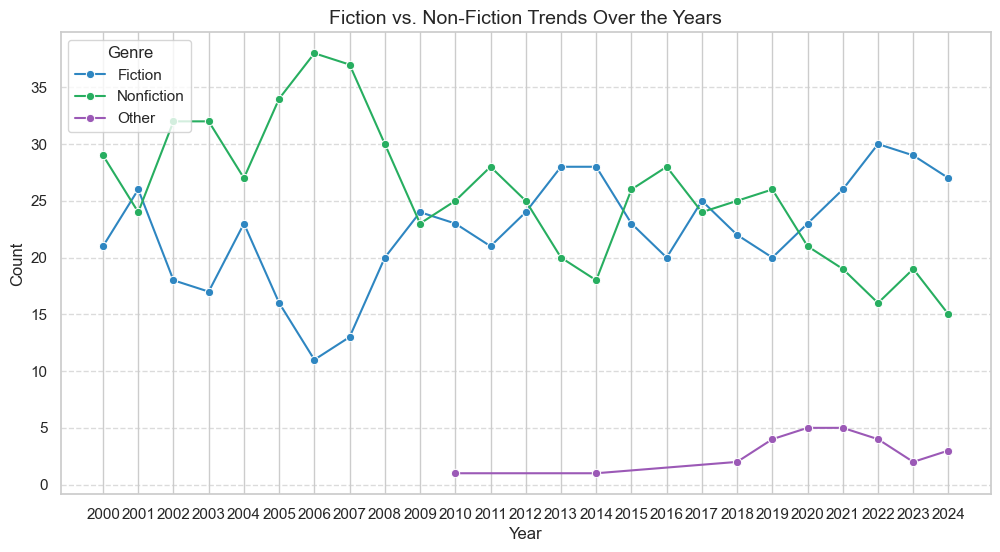

In [57]:
######################
## FROM HERE ONWARDS IS THE ANALYSIS OF THE AMAZON BESTSELLERS DATASET, WITH PLOTS AND TABLES, A BIT MESSY TO FOLLOW
######################



######################
## QUESTION 3.1: GENRE TRENDS
######################

# Group the data by year and genre, then count occurrences
genre_trends = books_df.groupby(["Year", "Genre"]).size().reset_index(name="Count")

# Define custom colors for all genres
genre_palette = {
    "Fiction": "#2E86C1",  # Blue
    "Non-Fiction": "#E74C3C",  # Red
    "Nonfiction": "#27AE60",  # Green
    "Other": "#9B59B6"  # Purple
}

# Create a line plot to show trends over the years
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=genre_trends,
    x="Year",
    y="Count",
    hue="Genre",
    marker="o",
    palette=genre_palette
)

# Add titles and labels
plt.title("Fiction vs. Non-Fiction Trends Over the Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Genre", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

#save plot as image
plt.savefig("plots/3_1_genre_trends.png")

# Show the plot
plt.show()


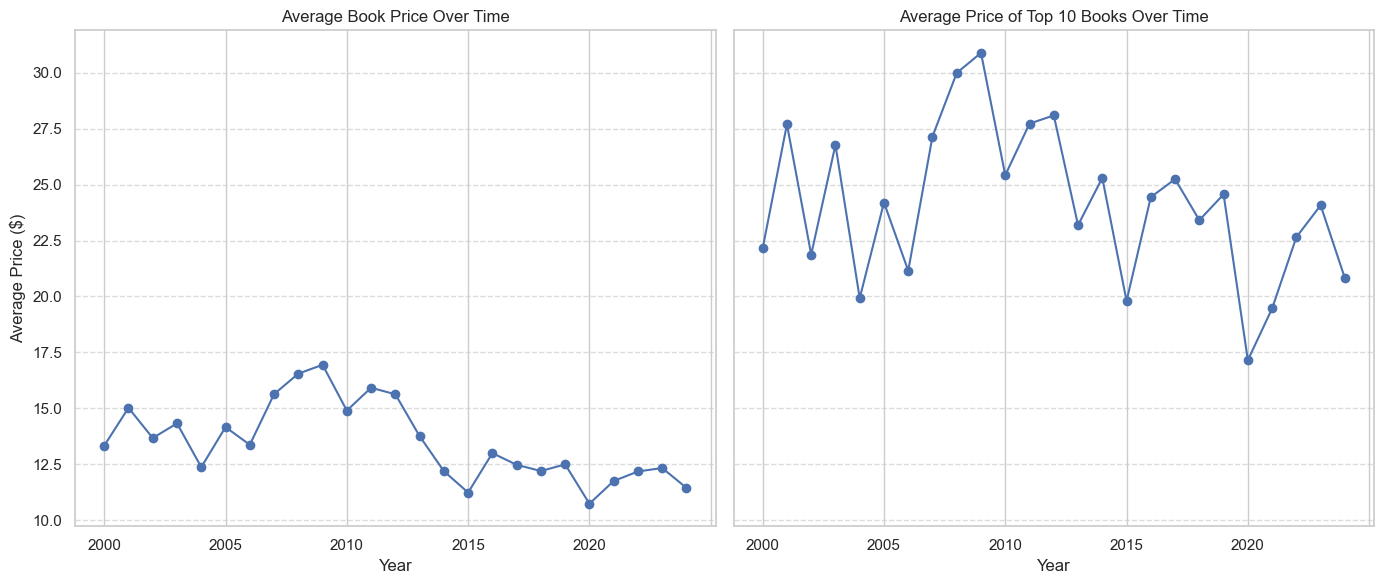

Average price of books with the Childrens genre: $9.08


In [79]:
######################
## QUESTION 3.2: PRICE TRENDS
######################

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Average book price over time
average_price_per_year = books_df.groupby("Year")["Price"].mean()

average_price_per_year.plot(ax=axes[0], kind="line", marker="o", title="Average Book Price Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Average Price ($)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

top_10_avg_price_per_year = books_df.groupby("Year")["Price"].nlargest(10).groupby("Year").mean()
# Average price of top 10 books each year
top_10_avg_price_per_year.plot(ax=axes[1], kind="line", marker="o", title="Average Price of Top 10 Books Over Time")
axes[1].set_xlabel("Year")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("plots/3_2_price_trends.png")
plt.show()

## Check what kind of format on the books are most expensive
books_df.groupby("Cover")["Price"].mean().sort_values(ascending=False)



#Average price of books with the Childrens genre
children_Avg_price = books_df[books_df["Genre"] == "Other"]["Price"].mean()
print(f"Average price of books with the Childrens genre: ${children_Avg_price:.2f}")





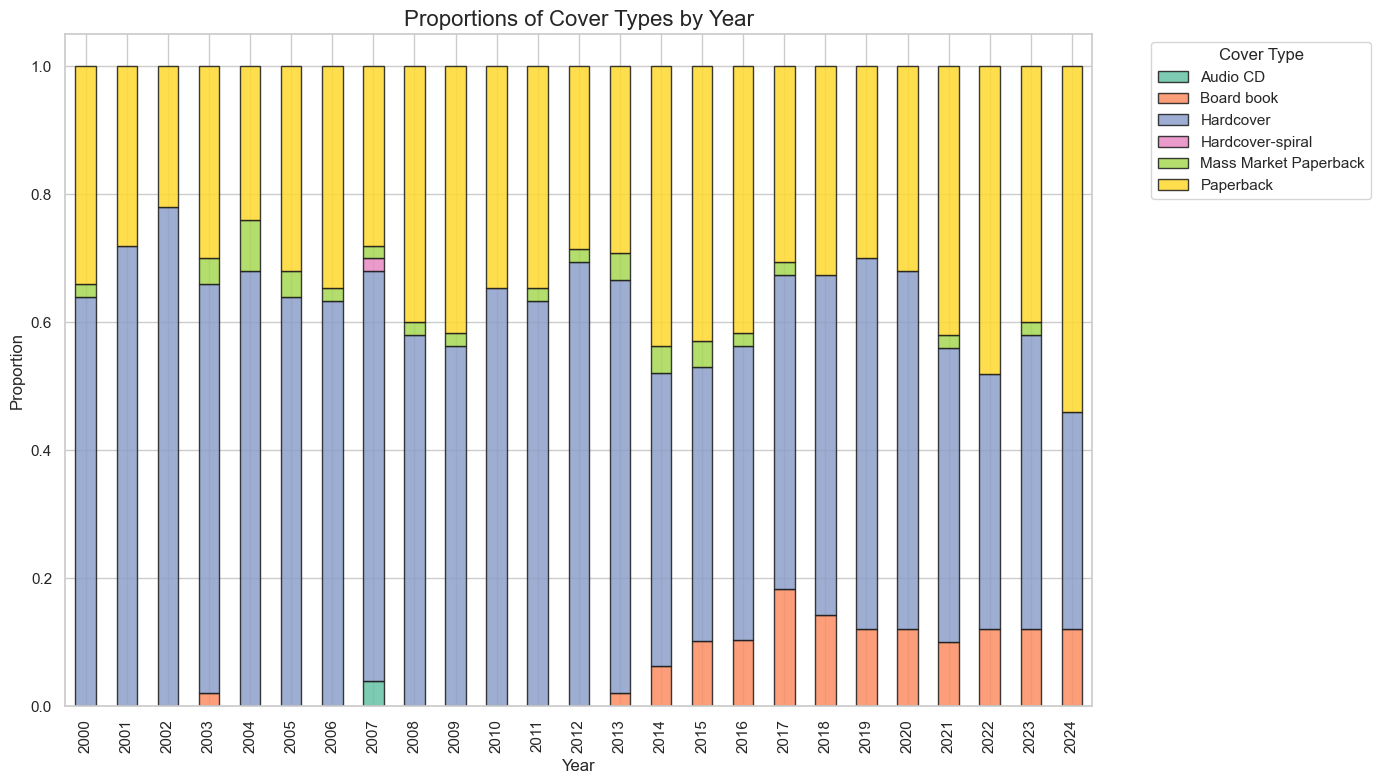

In [76]:
from matplotlib import colormaps

# Group by Year and Cover, then count occurrences
cover_proportions = books_df.groupby(["Year", "Cover"]).size().reset_index(name="Count")

# Calculate proportions for each cover type within a year
cover_proportions["Proportion"] = (
    cover_proportions.groupby("Year")["Count"]
    .transform(lambda x: x / x.sum())
)

# Define a visually appealing color map
colors = colormaps["Set2"].colors
cover_pivot = cover_proportions.pivot(index="Year", columns="Cover", values="Proportion").fillna(0)

# Plot the stacked bar chart with the new color scheme
cover_pivot.plot(kind="bar", stacked=True, figsize=(14, 8), color=colors, edgecolor="k", alpha=0.85)

# Customize plot appearance
plt.title("Proportions of Cover Types by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.legend(title="Cover Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.savefig("plots/3_2_cover_proportions.png")
# Show plot
plt.show()

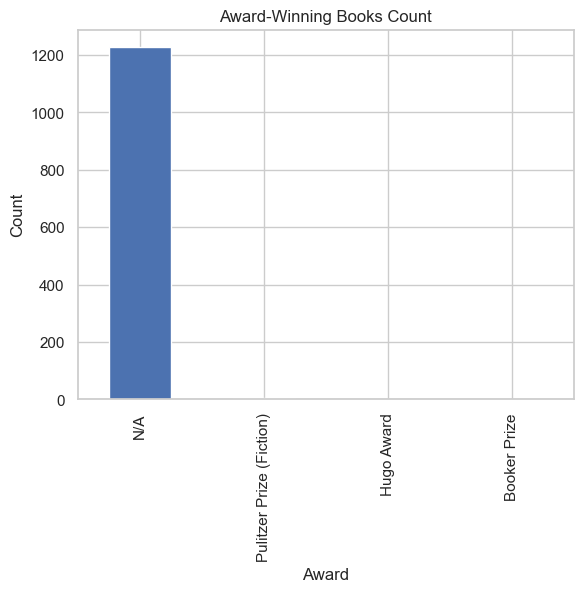

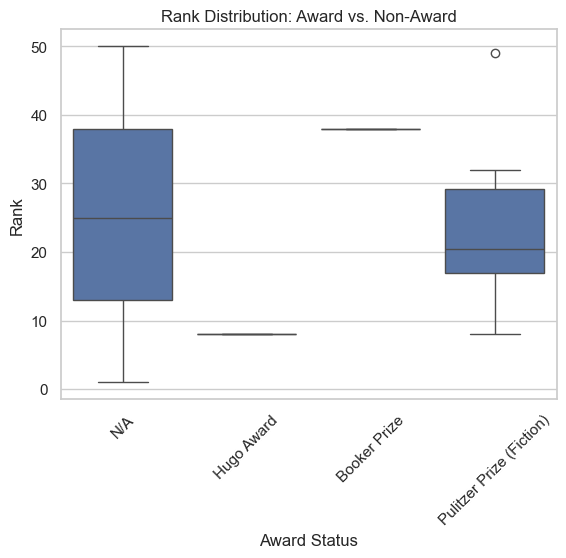

,Title,Author,Year,Award
57,Harry Potter and the Goblet of Fire (Harry Pot...,J.K. Rowling,2001,Hugo Award
137,Life of Pi,Yann Martel,2002,Booker Prize
148,Empire Falls,Richard Russo,2002,Pulitzer Prize (Fiction)
364,The Road (Oprah's Book Club),Cormac McCarthy,2007,Pulitzer Prize (Fiction)
480,Olive Kitteridge,Elizabeth Strout,2009,Pulitzer Prize (Fiction)
712,The Goldfinch: A Novel (Pulitzer Prize for Fic...,Donna Tartt,2014,Pulitzer Prize (Fiction)
747,All the Light We Cannot See,Anthony Doerr,2015,Pulitzer Prize (Fiction)
1154,Demon Copperhead: A Novel,Barbara Kingsolver,2023,Pulitzer Prize (Fiction)


In [77]:
######################
## QUESTION 3.3: AWARDS ANALYSIS
######################


award_counts = books_df["Award"].value_counts()
award_counts.plot(kind="bar", title="Award-Winning Books Count")
plt.xlabel("Award")
plt.ylabel("Count")

plt.savefig("plots/3_3_award_counts.png")

plt.show()

sns.boxplot(data=books_df, x="Award", y="Rank", order=["N/A"] + books_df["Award"].unique().tolist())
plt.title("Rank Distribution: Award vs. Non-Award")
plt.xlabel("Award Status")
plt.ylabel("Rank")
plt.xticks(rotation=45)

plt.savefig("plots/3_3_award_rank_distribution.png")

plt.show()

# Books with awards
books_with_awards = books_df[books_df["Award"] != "N/A"]
display(books_with_awards[["Title", "Author", "Year", "Award"]])

In [65]:
######################
## QUESTION 3.4: REPEAT BOOKS ON THE BESTSELLERS LIST
######################


unique_titles = books_df["Title"].nunique()
# Print the count of unique titles
print(f"Number of unique titles from 2000–2024: {unique_titles}")


title_counts = books_df["Title"].value_counts()

repeated_titles = books_df[books_df["Title"].duplicated(keep=False)]

# Group by Title and calculate the necessary metrics
aggregated_data = (
    repeated_titles.groupby("Title")
    .agg(
        Count=("Title", "size"),  # Count of occurrences
        Avg_Rank=("Rank", "mean"),  # Average rank
        Main_Genre=("Genre", lambda x: x.mode().iloc[0] if not x.mode().empty else "N/A"),  # Most frequent genre
    )
    .sort_values(by="Count", ascending=False)  # Sort by Count
    .reset_index()
)

# Select the top 50 repeated books
top_repeated_books_with_metrics = aggregated_data.head(10)

# Display the result
from IPython.display import display
display(top_repeated_books_with_metrics)



                                                 Title            Author  \
57   Harry Potter and the Goblet of Fire (Harry Pot...      J.K. Rowling   
137                                         Life of Pi       Yann Martel   
148                                       Empire Falls     Richard Russo   
364                       The Road (Oprah's Book Club)   Cormac McCarthy   
480                                   Olive Kitteridge  Elizabeth Strout   
747                        All the Light We Cannot See     Anthony Doerr   

     Year                     Award  
57   2001                Hugo Award  
137  2002              Booker Prize  
148  2002  Pulitzer Prize (Fiction)  
364  2007  Pulitzer Prize (Fiction)  
480  2009  Pulitzer Prize (Fiction)  
747  2015  Pulitzer Prize (Fiction)  
Number of unique titles from 2000–2024: 776


,Title,Count,Avg_Rank,Main_Genre
0,The Four Agreements: A Practical Guide to Pers...,14,21.714286,Nonfiction
1,"Oh, the Places You'll Go!",12,23.416667,Fiction
2,The Very Hungry Caterpillar,12,26.083333,Fiction
3,Good to Great: Why Some Companies Make the Lea...,12,17.750000,Nonfiction
4,The 7 Habits of Highly Effective People: Power...,11,33.181818,Nonfiction
5,StrengthsFinder 2.0,11,6.727273,Nonfiction
6,The Five Dysfunctions of a Team: A Leadership ...,11,25.090909,Nonfiction
7,Who Moved My Cheese,9,16.555556,Nonfiction
8,The 5 Love Languages: The Secret to Love that ...,8,20.500000,Nonfiction
9,"Now, Discover Your Strengths: The revolutionar...",8,12.625000,Nonfiction
